## DepMap:

Here we explore gene_effect_corrected.csv file from DepMap (https://ndownloader.figshare.com/files/14221385)
The gens that are essential for cell viability has effect size below the threshold -0.5. https://depmap.org/portal/faq/#dep_thresholds.

In [26]:
import csv
import wget
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import os
from collections import defaultdict



## Load the data
The “gene effect” file contains the corrected CERES scores, which measure the effect size of knocking out a gene, normalized against the distributions of non-essential and pan-essential genes. Columns are genes, rows are cell lines.
A more negative CERES score indicates depletion of the gene in that cell line, indicating that it is an essential gene for cell viability.

For simplicity, we call a gene "effective", if the effect size of that gene is below -0.5.

In [27]:
url = 'https://ndownloader.figshare.com/files/14221385'
filename = '../data/gene_effect_corrected.csv' # path to the file
    
    
if not os.path.exists(filename):
    wget.download(url,out="../data/")    
    
df_gene_effect = pd.read_csv(filename)

In [28]:
df_gene_effect.head()

,Unnamed: 0,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZUFSP (221302),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000004,0.134645,0.075536,-0.140209,0.013928,0.029131,-0.147284,0.275829,-0.363633,0.250165,...,-0.125018,-0.145802,-0.095429,-0.396903,0.205685,0.197798,-0.347782,0.212048,0.202099,-0.123465
1,ACH-000005,-0.212445,0.233124,0.044365,0.173837,-0.124389,-0.298849,0.120260,-0.339925,-0.011309,...,-0.142212,-0.377179,-0.109019,-0.544686,0.126581,0.033066,-0.060746,0.443834,-0.091548,0.065104
2,ACH-000007,0.043318,0.066838,-0.036197,0.134781,0.082996,0.119084,0.057116,-0.352541,-0.005800,...,-0.063270,-0.469378,-0.068437,-0.207803,0.158380,0.001434,-0.255654,0.065777,-0.314659,-0.358418
3,ACH-000009,0.070512,0.008430,0.027114,0.055927,0.046325,0.015968,0.053502,-0.498860,0.110794,...,0.114418,-0.374999,-0.204950,-0.196839,0.043411,0.018276,-0.398310,0.151885,-0.124333,-0.391758
4,ACH-000011,0.190935,0.083952,-0.000741,0.353375,-0.037044,-0.205803,0.071275,-0.317310,0.099824,...,0.052517,-0.510975,-0.345998,-0.408631,0.241005,0.141594,-0.177939,0.092722,-0.161591,-0.329937


In [33]:
columns_depmap = df_gene_effect.columns
number_genes = df_gene_effect.shape[1]-1
number_cell_lines = df_gene_effect.shape[0]
print("number of genes:{}".format(number_genes))
print("number of cell lines:{}".format(number_cell_lines))


number of genes:17634
number of cell lines:558


## Map gene symbols to ensembl IDs

In [34]:
symbol_lookup = defaultdict(str)
with open( '../lookup/lookup.txt', 'r') as f:
        next(f)  # skip header
        for line in f:
            fields = line.split('\t')
            symbol = fields[0]
            ncbi_id = fields[1]
            ensembl = fields[2]
            symbol_lookup[symbol] = ensembl


## Create a dataframe for gene_effect_correct data where columns are gene ensembl IDs.
1. Frist, we find the gene ensembl id for each gene symbol in the columns of the gene_effect_corrected. 
2. We add the list of gene ensembl ids to the rows of the dataframe
3. We replace the original header which has gene symbols by the gene ensembl IDs.

In [36]:
# find the ensembl id for each gene symbol in the header of the gene_effect_corrected file.
# We find the number of gene symbols that are successfully mapped to gene ensembl ids and get the ratio of gene 
#symbols that are mapped.
header_gene_ids = []
genes_not_mapped = []
number_mapped_genes = 0
columns_genes_mapped = []
for col in columns_depmap:
    gene = col.split(" ")
    gene_symbole = gene[0] 
    gene_ncbi_id = gene[1]
    ensembl = symbol_lookup[gene_symbole]
    if ensembl != "":
        number_mapped_genes += 1
        columns_genes_mapped.append(col)
        header_gene_ids.append(ensembl)
    else:
        genes_not_mapped.append(gene_symbole)
print("number of gene symbols that were mapped to gene IDs:", number_mapped_genes)
print("ratio of genes that were mapped to gene IDs to the total number of genes of the gene effect file", number_mapped_genes/number_genes)


number of gene symbols that were mapped to gene IDs: 16732
ratio of genes that were mapped to gene IDs to the total number of genes of the gene effect file 0.948848814789611


In [37]:
#construct a new dataframe with genes that are mapped to gene ensembl ids.
new_df = df_gene_effect[columns_genes_mapped]
new_df.head()

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZSWIM7 (125150),ZSWIM8 (23053),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140)
0,0.134645,0.075536,-0.140209,0.013928,0.029131,-0.147284,0.275829,-0.363633,0.250165,0.129743,...,-0.173068,-0.124833,-0.145802,-0.095429,-0.396903,0.205685,0.197798,-0.347782,0.212048,0.202099
1,-0.212445,0.233124,0.044365,0.173837,-0.124389,-0.298849,0.120260,-0.339925,-0.011309,0.015660,...,-0.157870,-0.127058,-0.377179,-0.109019,-0.544686,0.126581,0.033066,-0.060746,0.443834,-0.091548
2,0.043318,0.066838,-0.036197,0.134781,0.082996,0.119084,0.057116,-0.352541,-0.005800,0.241488,...,-0.154457,-0.105315,-0.469378,-0.068437,-0.207803,0.158380,0.001434,-0.255654,0.065777,-0.314659
3,0.070512,0.008430,0.027114,0.055927,0.046325,0.015968,0.053502,-0.498860,0.110794,0.066921,...,-0.329543,-0.147972,-0.374999,-0.204950,-0.196839,0.043411,0.018276,-0.398310,0.151885,-0.124333
4,0.190935,0.083952,-0.000741,0.353375,-0.037044,-0.205803,0.071275,-0.317310,0.099824,0.105539,...,-0.317330,-0.104482,-0.510975,-0.345998,-0.408631,0.241005,0.141594,-0.177939,0.092722,-0.161591


In [18]:
#create a dataframe with only one row of gene ensembl ids.
df_new_row = pd.DataFrame([header_gene_ids], columns = new_df.columns)
df_new_row.head()
df_new_row.shape

(1, 16732)

In [19]:
#add the row of gene ensembl ids to the dataframe constructed from genes that are mapped to gene ensembl ids.
#This row is added to the last row
df_temp = new_df.append(df_new_row, ignore_index=True)
df_temp.head()

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZSWIM7 (125150),ZSWIM8 (23053),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140)
0,0.134645,0.0755363,-0.140209,0.0139284,0.029131,-0.147284,0.275829,-0.363633,0.250165,0.129743,...,-0.173068,-0.124833,-0.145802,-0.0954286,-0.396903,0.205685,0.197798,-0.347782,0.212048,0.202099
1,-0.212445,0.233124,0.0443649,0.173837,-0.124389,-0.298849,0.12026,-0.339925,-0.0113095,0.0156595,...,-0.15787,-0.127058,-0.377179,-0.109019,-0.544686,0.126581,0.033066,-0.0607463,0.443834,-0.0915483
2,0.0433179,0.0668376,-0.0361965,0.134781,0.0829956,0.119084,0.057116,-0.352541,-0.00579964,0.241488,...,-0.154457,-0.105315,-0.469378,-0.0684374,-0.207803,0.15838,0.00143431,-0.255654,0.0657771,-0.314659
3,0.070512,0.00842976,0.0271142,0.0559268,0.0463254,0.0159683,0.0535023,-0.49886,0.110794,0.0669212,...,-0.329543,-0.147972,-0.374999,-0.20495,-0.196839,0.0434114,0.0182759,-0.39831,0.151885,-0.124333
4,0.190935,0.0839524,-0.000740788,0.353375,-0.0370438,-0.205803,0.0712754,-0.31731,0.0998241,0.105539,...,-0.31733,-0.104482,-0.510975,-0.345998,-0.408631,0.241005,0.141594,-0.177939,0.0927217,-0.161591


In [20]:
#replacing the last row with the first row
b, c = df_temp.iloc[0], df_temp.iloc[df_temp.shape[0]-1]

temp = df_temp.iloc[0].copy()
df_temp.iloc[0] = c
df_temp.iloc[df_temp.shape[0]-1] = temp
df_temp.head()

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZSWIM7 (125150),ZSWIM8 (23053),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140)
0,ENSG00000121410,ENSG00000148584,ENSG00000175899,ENSG00000166535,ENSG00000184389,ENSG00000128274,ENSG00000118017,ENSG00000094914,ENSG00000081760,ENSG00000114771,...,ENSG00000214941,ENSG00000214655,ENSG00000086827,ENSG00000174442,ENSG00000122952,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755
1,-0.212445,0.233124,0.0443649,0.173837,-0.124389,-0.298849,0.12026,-0.339925,-0.0113095,0.0156595,...,-0.15787,-0.127058,-0.377179,-0.109019,-0.544686,0.126581,0.033066,-0.0607463,0.443834,-0.0915483
2,0.0433179,0.0668376,-0.0361965,0.134781,0.0829956,0.119084,0.057116,-0.352541,-0.00579964,0.241488,...,-0.154457,-0.105315,-0.469378,-0.0684374,-0.207803,0.15838,0.00143431,-0.255654,0.0657771,-0.314659
3,0.070512,0.00842976,0.0271142,0.0559268,0.0463254,0.0159683,0.0535023,-0.49886,0.110794,0.0669212,...,-0.329543,-0.147972,-0.374999,-0.20495,-0.196839,0.0434114,0.0182759,-0.39831,0.151885,-0.124333
4,0.190935,0.0839524,-0.000740788,0.353375,-0.0370438,-0.205803,0.0712754,-0.31731,0.0998241,0.105539,...,-0.31733,-0.104482,-0.510975,-0.345998,-0.408631,0.241005,0.141594,-0.177939,0.0927217,-0.161591


In [21]:
#make the first row the header
new_header = df_temp.iloc[0] #grab the first row for the header
df = df_temp[1:] #take the data less the header row
df.columns = new_header 
df.head()

,ENSG00000121410,ENSG00000148584,ENSG00000175899,ENSG00000166535,ENSG00000184389,ENSG00000128274,ENSG00000118017,ENSG00000094914,ENSG00000081760,ENSG00000114771,...,ENSG00000214941,ENSG00000214655,ENSG00000086827,ENSG00000174442,ENSG00000122952,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755
1,-0.212445,0.233124,0.0443649,0.173837,-0.124389,-0.298849,0.12026,-0.339925,-0.0113095,0.0156595,...,-0.15787,-0.127058,-0.377179,-0.109019,-0.544686,0.126581,0.033066,-0.0607463,0.443834,-0.0915483
2,0.0433179,0.0668376,-0.0361965,0.134781,0.0829956,0.119084,0.057116,-0.352541,-0.00579964,0.241488,...,-0.154457,-0.105315,-0.469378,-0.0684374,-0.207803,0.15838,0.00143431,-0.255654,0.0657771,-0.314659
3,0.070512,0.00842976,0.0271142,0.0559268,0.0463254,0.0159683,0.0535023,-0.49886,0.110794,0.0669212,...,-0.329543,-0.147972,-0.374999,-0.20495,-0.196839,0.0434114,0.0182759,-0.39831,0.151885,-0.124333
4,0.190935,0.0839524,-0.000740788,0.353375,-0.0370438,-0.205803,0.0712754,-0.31731,0.0998241,0.105539,...,-0.31733,-0.104482,-0.510975,-0.345998,-0.408631,0.241005,0.141594,-0.177939,0.0927217,-0.161591
5,-0.0104471,0.142187,0.153432,0.255571,0.019884,-0.10793,0.238418,-0.396809,0.0531139,0.274086,...,-0.379597,-0.260046,-0.41245,-0.295652,-0.670075,0.0790975,0.115441,-0.0635642,0.0139935,-0.150988


In [22]:
df.insert(0,'col0',df_gene_effect["Unnamed: 0"])
df.head()

,col0,ENSG00000121410,ENSG00000148584,ENSG00000175899,ENSG00000166535,ENSG00000184389,ENSG00000128274,ENSG00000118017,ENSG00000094914,ENSG00000081760,...,ENSG00000214941,ENSG00000214655,ENSG00000086827,ENSG00000174442,ENSG00000122952,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755
1,ACH-000005,-0.212445,0.233124,0.0443649,0.173837,-0.124389,-0.298849,0.12026,-0.339925,-0.0113095,...,-0.15787,-0.127058,-0.377179,-0.109019,-0.544686,0.126581,0.033066,-0.0607463,0.443834,-0.0915483
2,ACH-000007,0.0433179,0.0668376,-0.0361965,0.134781,0.0829956,0.119084,0.057116,-0.352541,-0.00579964,...,-0.154457,-0.105315,-0.469378,-0.0684374,-0.207803,0.15838,0.00143431,-0.255654,0.0657771,-0.314659
3,ACH-000009,0.070512,0.00842976,0.0271142,0.0559268,0.0463254,0.0159683,0.0535023,-0.49886,0.110794,...,-0.329543,-0.147972,-0.374999,-0.20495,-0.196839,0.0434114,0.0182759,-0.39831,0.151885,-0.124333
4,ACH-000011,0.190935,0.0839524,-0.000740788,0.353375,-0.0370438,-0.205803,0.0712754,-0.31731,0.0998241,...,-0.31733,-0.104482,-0.510975,-0.345998,-0.408631,0.241005,0.141594,-0.177939,0.0927217,-0.161591
5,ACH-000012,-0.0104471,0.142187,0.153432,0.255571,0.019884,-0.10793,0.238418,-0.396809,0.0531139,...,-0.379597,-0.260046,-0.41245,-0.295652,-0.670075,0.0790975,0.115441,-0.0635642,0.0139935,-0.150988


In [24]:
columns = df.columns


## Statistics
For each gene, we find the effect size of that gene in each cell line and count the number of 
effect sizes that are less than -0.5. We then divide this number by the total number of cell lines to
get the proportion of effect sizes below -0.5 for each gene.
We also find the number of genes that have at least one effect size below -0.5. 
We count the numbe of genes that their effect size is below threshold in all cell lines.

In [25]:
threshold = -0.5
effective_genes = [] #list of effective genes
proportion_effective_genes_in_cell_lines = [] 
number_effective_genes = 0 #number of genes with at least one effect size below threshold
number_effective_genes_in_all_cell_lines = 0 #number of genes that thier effect sizes are less than threshold in all cell lines.
for i in range(1,df.shape[1]):
    col = columns[i]
    df_col = df.loc[:,col]#dataframe corresponding to a gene (column)
    gene_effect_df = df_col.loc[df.loc[:,col] < threshold] #dataframe corresponding to a gene(column) with effect sizes below threshold
    proportion_effective_gene_in_cell_lines = gene_effect_df.shape[0] / df.shape[0]
    if proportion_effective_gene_in_cell_lines > 0:
        number_effective_genes += 1
        effective_genes.append(i)
        proportion_effective_genes_in_cell_lines.append(proportion_effective_gene_in_cell_lines)
    if proportion_effective_gene_in_cell_lines == 1.0:
        number_effective_genes_in_all_cell_lines += 1

print("total number of genes: {}".format(df.shape[1]))        
print("number of effective genes (genes that have an effect size below -0.5 in at least one cell line): {}"
      .format(number_effective_genes))
print("number of genes that are effective in ALL cell lines (have effect size below -0.5 in all cell lines): {}".format(number_effective_genes_in_all_cell_lines))

total number of genes: 16733
number of effective genes (genes that have an effect size below -0.5 in at least one cell line): 8978
number of genes that are effective in ALL cell lines (have effect size below -0.5 in all cell lines): 260


## Data Visualization
For each gene, we plot the proprtion of cell lines in which the gene is effective (has effect size below the threshold). Here, we only plot the proportion for the first 3000 of effective genes.

Text(0.5, 1.0, 'proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

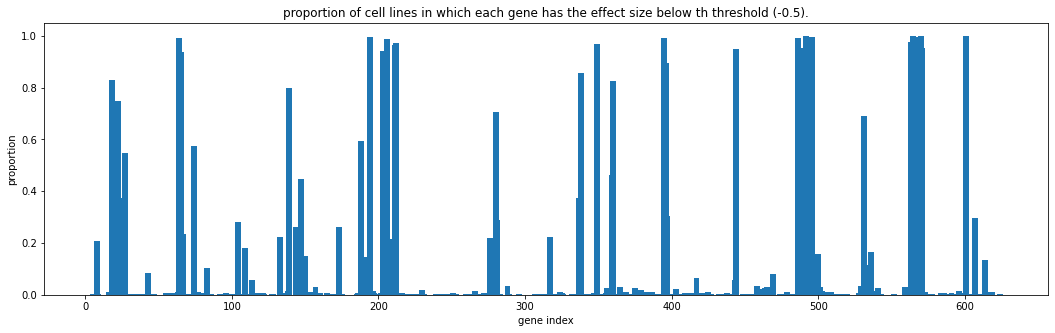

In [15]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(effective_genes[0:300],proportion_effective_genes_in_cell_lines[0:300],width=4)
plt.xlabel('gene index')
plt.ylabel('proportion')
plt.title('proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

Text(0.5, 1.0, 'proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

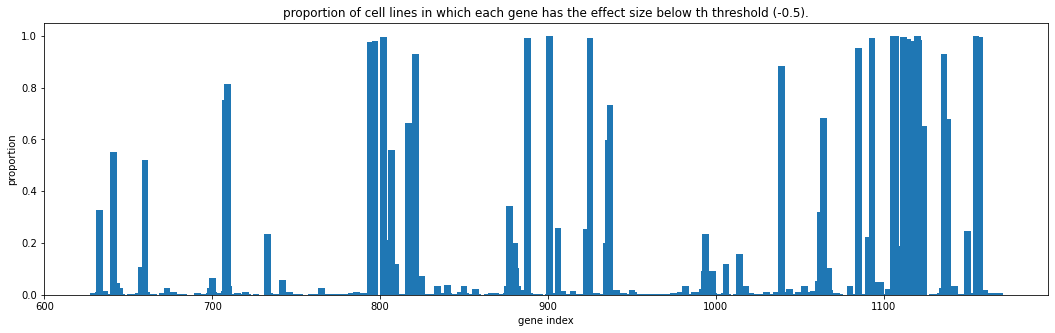

In [16]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(effective_genes[301:600],proportion_effective_genes_in_cell_lines[301:600],  width=4)
plt.xlabel('gene index')
plt.ylabel('proportion')
plt.title('proportion of cell lines in which each gene has the effect size below the threshold (-0.5).')

Text(0.5, 1.0, 'proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

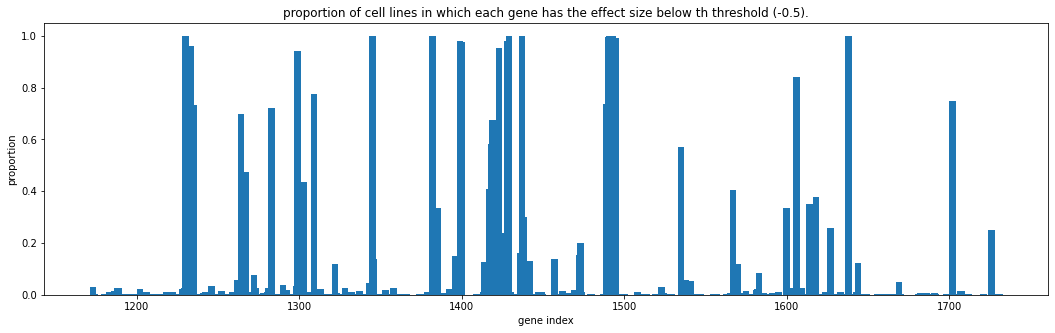

In [17]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(effective_genes[601:900],proportion_effective_genes_in_cell_lines[601:900],  width=4)
plt.xlabel('gene index')
plt.ylabel('proportion')
plt.title('proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

Text(0.5, 1.0, 'proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

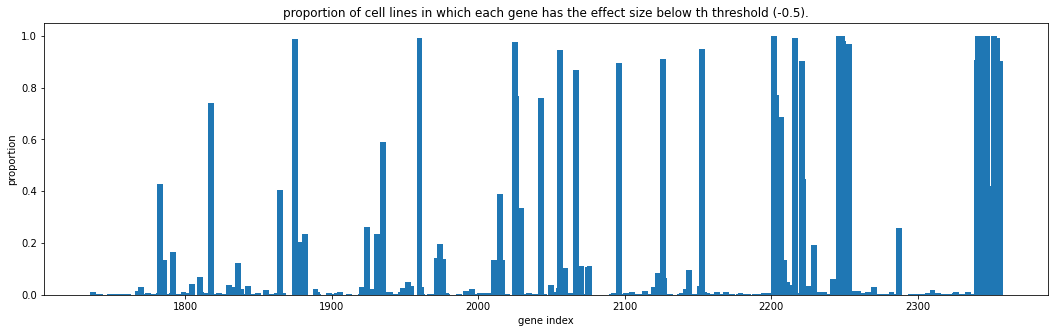

In [18]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(effective_genes[901:1200],proportion_effective_genes_in_cell_lines[901:1200],  width=4)
plt.xlabel('gene index')
plt.ylabel('proportion')
plt.title('proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

Text(0.5, 1.0, 'proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

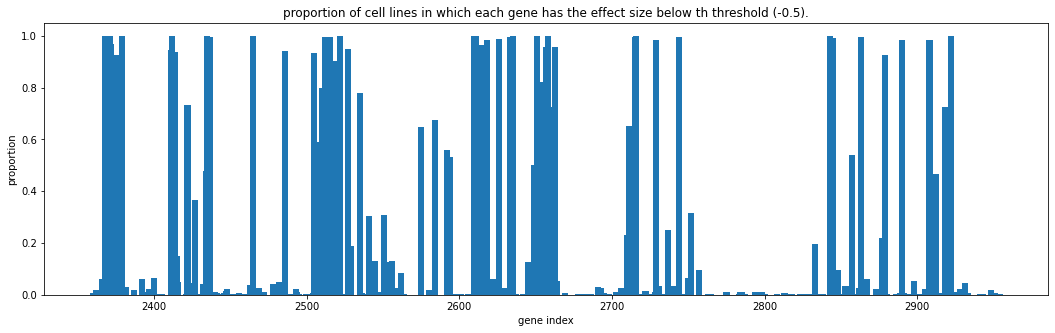

In [19]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(effective_genes[1201:1500],proportion_effective_genes_in_cell_lines[1201:1500],  width=4)
plt.xlabel('gene index')
plt.ylabel('proportion')
plt.title('proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

Text(0.5, 1.0, 'proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

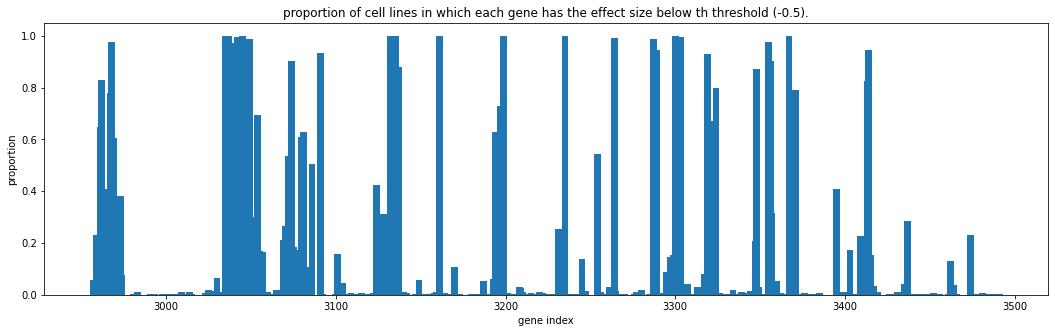

In [20]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(effective_genes[1501:1800],proportion_effective_genes_in_cell_lines[1501:1800],  width=4)
plt.xlabel('gene index')
plt.ylabel('proportion')
plt.title('proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

Text(0.5, 1.0, 'proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

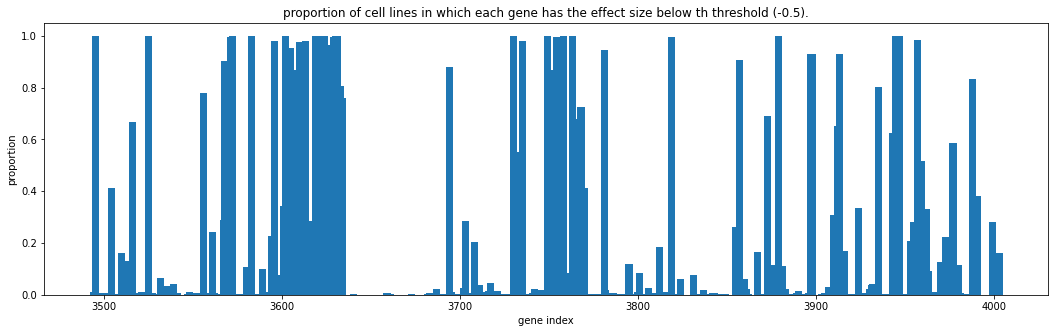

In [21]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(effective_genes[1801:2100],proportion_effective_genes_in_cell_lines[1801:2100],  width=4)
plt.xlabel('gene index')
plt.ylabel('proportion')
plt.title('proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

Text(0.5, 1.0, 'proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

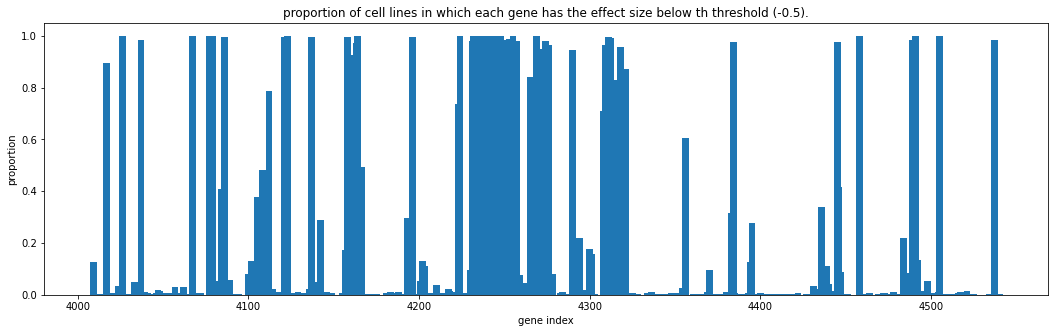

In [22]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(effective_genes[2101:2400],proportion_effective_genes_in_cell_lines[2101:2400],  width=4)
plt.xlabel('gene index')
plt.ylabel('proportion')
plt.title('proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

Text(0.5, 1.0, 'proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

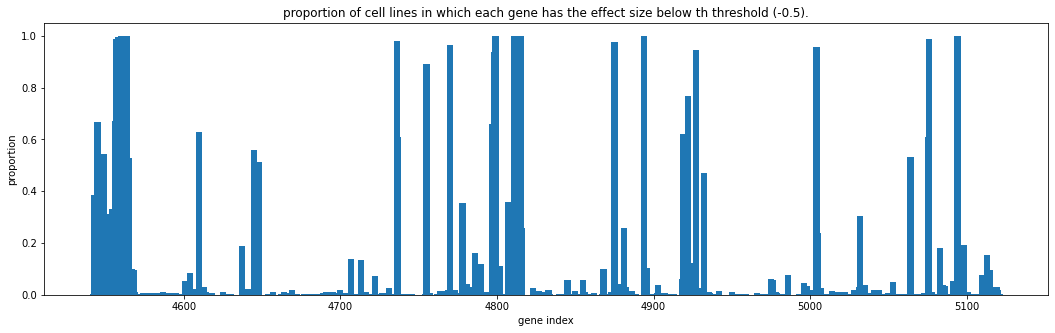

In [23]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(effective_genes[2401:2700],proportion_effective_genes_in_cell_lines[2401:2700],  width=4)
plt.xlabel('gene index')
plt.ylabel('proportion')
plt.title('proportion of cell lines in which each gene has the effect size below th threshold (-0.5).')

Text(0.5, 1.0, 'proportion of cell lines in which each gene has the effect size below the threshold (-0.5).')

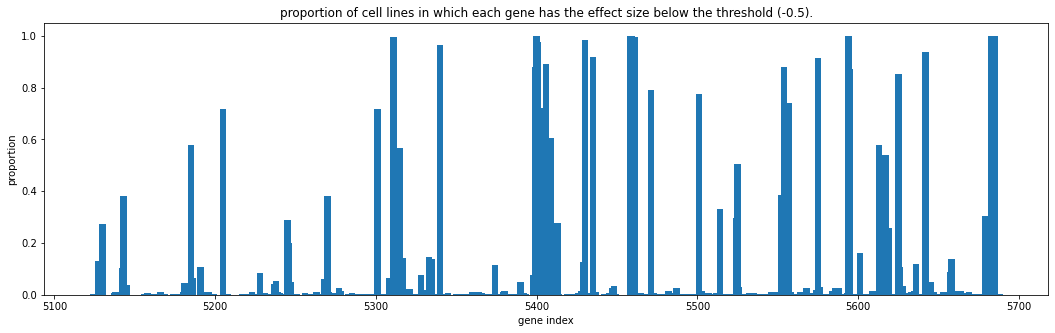

In [24]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(effective_genes[2701:3000],proportion_effective_genes_in_cell_lines[2701:3000],  width=4)
plt.xlabel('gene index')
plt.ylabel('proportion')
plt.title('proportion of cell lines in which each gene has the effect size below the threshold (-0.5).')

## More on Statistics
For each cell line, we find the number of genes that have effect size below -0.5. 

First, we create a transpose of the data. Now, the genes are rows and cell lines are columns.

In [25]:
df_tr = df.T
new_header = df_tr.iloc[0] #grab the first row for the header
df_tr = df_tr[1:] #take the data less the header row
df_tr.columns = new_header 
df_tr.head()

col0,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,ACH-000018,...,ACH-001552,ACH-001554,ACH-001654,ACH-001735,ACH-001736,ACH-001737,ACH-001740,ACH-001745,ACH-001765,NaN
0,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,-0.212445,0.0433179,0.070512,0.190935,-0.0104471,0.0209754,0.112979,-0.0741717,0.133124,-0.0402206,...,0.110189,0.0870783,0.146562,0.0937598,0.105938,-0.0477324,0.0127093,0.144255,0.0949538,0.134645
ENSG00000148584,0.233124,0.0668376,0.00842976,0.0839524,0.142187,0.032739,-0.0353325,0.00849296,0.0810082,0.0648516,...,0.049046,-0.0363506,0.142085,0.0329477,0.00430378,0.120031,0.285957,0.124366,0.01946,0.0755363
ENSG00000175899,0.0443649,-0.0361965,0.0271142,-0.000740788,0.153432,-0.0463228,0.0288061,-0.0938462,-0.0455446,-0.247315,...,-0.230648,-0.060726,-0.0481822,-0.0146596,-0.0796221,-0.0257498,-0.130755,-0.0800136,-0.0657601,-0.140209
ENSG00000166535,0.173837,0.134781,0.0559268,0.353375,0.255571,0.15352,0.169334,0.116199,0.0967302,0.177751,...,0.285429,0.172627,0.180256,0.156474,0.0553825,0.114416,0.193217,0.148146,0.0795169,0.0139284
ENSG00000184389,-0.124389,0.0829956,0.0463254,-0.0370438,0.019884,-0.036985,-0.00359193,-0.0244968,-0.146274,0.0703194,...,-0.252451,-0.0891275,-0.0150777,-0.0771064,-0.167184,0.145926,-0.0409575,-0.092386,-0.0916134,0.029131


In [26]:
threshold = -0.5
cell_lines = []# list of cell lines in which at least one gene has effect size below threshold
proportion = [] #ratio of number of cell lines in which a gene has effect size below threshold to the total number of
#genes
number_effective_genes_in_cell_line = []
number_cell_lines = 0 #number of cell lines in which at least one gene has effect size below threshold
number_cell_lines_all_genes_effective = 0#number of cell lines in which all genes are effective (have effec 
#score lss than threshold)

for i in range(df_tr.shape[1]):
    col = df_tr.columns[i]
    df_tr_col = df_tr.loc[:,col]
    cell_line_df = df_tr_col.loc[df_tr.loc[:,col] < threshold]
    number_effective_genes = cell_line_df.shape[0]
    proportion_effective_genes_in_a_cell_line = cell_line_df.shape[0] / df_tr.shape[0]
    if proportion_effective_genes_in_a_cell_line > 0:
        number_cell_lines += 1
        cell_lines.append(i)
        proportion.append(proportion_effective_genes_in_a_cell_line)
        number_effective_genes_in_cell_line.append(number_effective_genes)
    if proportion_effective_genes_in_a_cell_line == 1.0:
        number_cell_lines_all_genes_effective += 1

print("total number of cell lines: {}".format(df_tr.shape[1]))        
print("number of cell lines that there is at least one gene with the effect score below -0.5: {}"
      .format(number_cell_lines))
print("number of cell lines in which all genes are effective: {}".format(number_cell_lines_all_genes_effective))

total number of cell lines: 558
number of cell lines that there is at least one gene with the effect score below -0.5: 558
number of cell lines in which all genes are effective: 0


## Data Visualization
We plot number of genes that are effective in each cell line.We call a gene effctive if its effect 
size is below -0.5

Text(0.5, 1.0, 'number of genes that are effective in each cell line.')

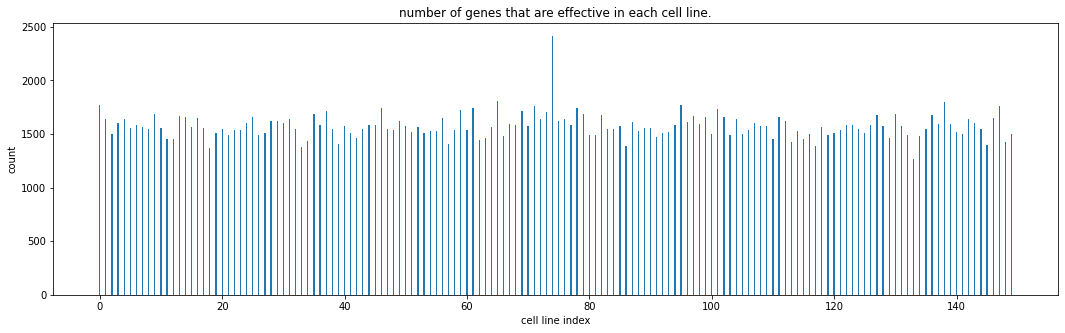

In [27]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(cell_lines[0:150],number_effective_genes_in_cell_line[0:150],  width=0.2)
plt.xlabel('cell line index')
plt.ylabel('count')
plt.title('number of genes that are effective in each cell line.')

Text(0.5, 1.0, 'number of genes that are effective in each cell line.')

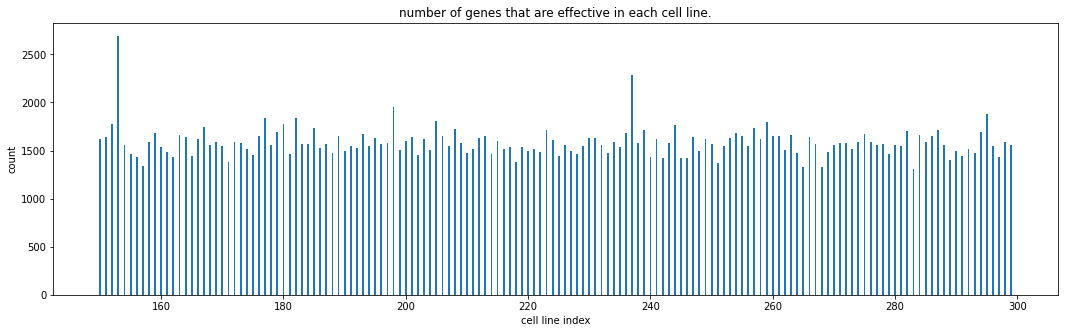

In [28]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(cell_lines[150:300],number_effective_genes_in_cell_line[150:300],  width=0.3)
plt.xlabel('cell line index')
plt.ylabel('count')
plt.title('number of genes that are effective in each cell line.')

Text(0.5, 1.0, 'numberof genes that are effective in each cell line.')

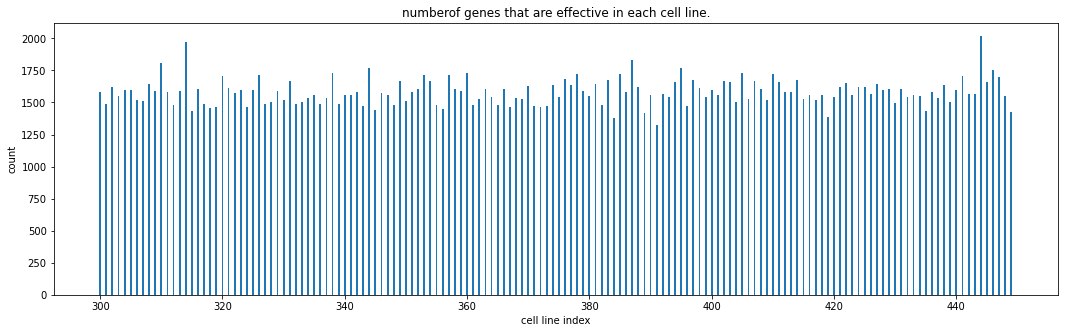

In [29]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(cell_lines[300:450],number_effective_genes_in_cell_line[300:450],  width=0.3)
plt.xlabel('cell line index')
plt.ylabel('count')
plt.title('numberof genes that are effective in each cell line.')

Text(0.5, 1.0, 'number of genes that are effective in each cell line.')

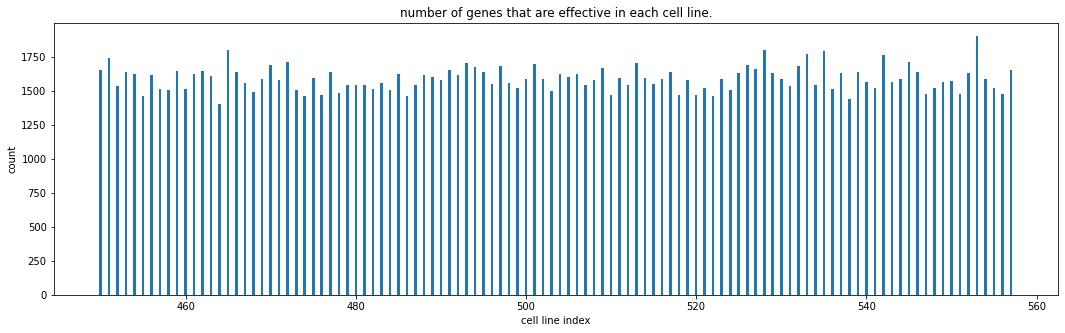

In [30]:
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(cell_lines[450:559],number_effective_genes_in_cell_line[450:559],  width=0.3)
plt.xlabel('cell line index')
plt.ylabel('count')
plt.title('number of genes that are effective in each cell line.')